In [1]:
import h5py
import time
import torch
import pyreadr
import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
from pandas.api.types import CategoricalDtype
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils import weight_norm
from sklearn.manifold import TSNE
from livelossplot import PlotLosses
from pytorch_model_summary import summary
from tqdm.notebook import tqdm, trange

device = torch.device('cuda')

In [2]:
from joblib import dump, load
from sklearn import metrics
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [3]:
class MyDataset(torch.utils.data.Dataset):
    '''
    Class to load the dataset
    '''
    def __init__(self, w, y, idx):
        self.w = w
        self.y = y
        self.idx = idx
            
    def __len__(self):
        return len(self.idx)

    def __getitem__(self, idx):
            
        idx = self.idx[idx]
        
        ww = torch.tensor(self.w[idx], dtype=torch.float, device = device)
        yy = torch.tensor(self.y[idx], dtype=torch.float, device = device)
        
        return (ww, yy)

In [4]:
class MyNet(nn.Module):

    def __init__(self, w_layers, pred_layers):

        super().__init__()
              
        # Weaher variables
        w_layers_list = nn.ModuleList()
        for i, o, k, d in w_layers:
            w_layer = nn.Sequential(
                nn.Conv1d(i, o, k),
                nn.AvgPool1d(2),
                nn.LeakyReLU(),
                nn.BatchNorm1d(o),
                nn.Dropout(d)
            )
            w_layers_list.append(w_layer)
        w_layers_list.append(nn.AdaptiveAvgPool1d(1))
        self.w_layers = nn.Sequential(*w_layers_list)

        
        # Management variables
        pred_layers_list = nn.ModuleList()
        for i, o, d in pred_layers:
            pred_layer = nn.Sequential(
                nn.Linear(i, o),
                nn.LeakyReLU(),
                nn.BatchNorm1d(o),
                nn.Dropout(d)
            )
            pred_layers_list.append(pred_layer)
        pred_layers_list.append(nn.Linear(o, 1))
        self.pred_layers = nn.Sequential(*pred_layers_list)
        
   
    def forward(self, Ws):
        
        feat = self.w_layers(Ws).view(Ws.shape[0], -1)
        pred = self.pred_layers(feat)
        return (torch.tanh(pred))


In [5]:
w_file = '../data/w_np.npy'
w = np.load(w_file)
ws = np.array([[[5e4,50,50,5,10,100]]])
w = w / ws
W = np.moveaxis(w, 1, 2)
wd = np.linspace(-0.9,2.1,300)[None,None]
wd = wd.repeat(len(W), 0)
W = np.concatenate([W, wd], 1)

In [6]:
np_df = pd.read_hdf('../data/PSCE_npff.h5', key = 'SIM').sort_values('SIM')
y = np_df.TWSO.values[:,None]/2e4

In [7]:
idx_max = y[:,0].argmax()
idx_min = y[:,0].argmin()

In [8]:
pred_idx = np.arange(len(y))
val_idx = np.random.choice(pred_idx, size=300, replace=False)
train_idx = np.setdiff1d(pred_idx, val_idx)
print(train_idx.shape, val_idx.shape)

(4294,) (300,)


In [9]:
batch_size = 1000

pred_dataset = MyDataset(W, y, pred_idx)
train_dataset = MyDataset(W, y, train_idx)
val_dataset = MyDataset(W, y, val_idx)


pred_loader = DataLoader(pred_dataset, batch_size=batch_size, shuffle=False)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

data_inputs = iter(train_loader).next()
print(len(train_loader))



5


In [10]:
d = 0.5
w_layers =  [[7,12,3,d],[12,15,5,d],[15,20,7,d],[20,25,5,d],[25,100,3,d]]
pred_layers = [[100,50,d],[50,50,d], [50,25,d]]

model = MyNet(w_layers, pred_layers)
model = model.to(device)
    
# model_file_name = '../data/model_cnn.pth'
# model.load_state_dict(torch.load(model_file_name, map_location=device))
# model_file_name = '../data/model_cnn_adv.pth'
# model_file_name = '../data/model_cnn_rnd010.pth'
model_file_name = '../data/model_cnn_rnd000.pth'


sm = summary(model, data_inputs[0], print_summary=True,  max_depth=1)

----------------------------------------------------------------------------
           Layer (type)        Output Shape         Param #     Tr. Param #
               Conv1d-1     [1000, 12, 298]             264             264
            AvgPool1d-2     [1000, 12, 149]               0               0
            LeakyReLU-3     [1000, 12, 149]               0               0
          BatchNorm1d-4     [1000, 12, 149]              24              24
              Dropout-5     [1000, 12, 149]               0               0
               Conv1d-6     [1000, 15, 145]             915             915
            AvgPool1d-7      [1000, 15, 72]               0               0
            LeakyReLU-8      [1000, 15, 72]               0               0
          BatchNorm1d-9      [1000, 15, 72]              30              30
             Dropout-10      [1000, 15, 72]               0               0
              Conv1d-11      [1000, 20, 66]           2,120           2,120
           

In [11]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [12]:
min_loss = 10
bad_epochs = 0
liveloss = PlotLosses()

In [13]:
rnd = torch.tensor(0.1 * W.std((0,2))[:-1], device = device)[None,:,None]

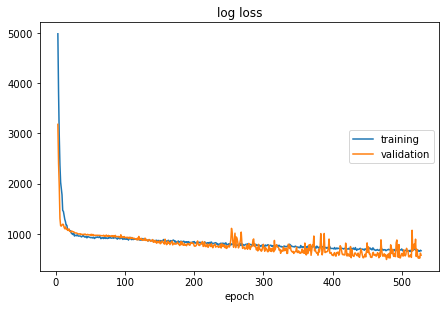

log loss:
training   (min:  647.534, max: 11372.772, cur:  665.269)
validation (min:  490.284, max: 4572.601, cur:  575.550)
[50:527] loss: 0.001 time:0.77


In [14]:
for epoch in range(1000):
    start_time = time.time()
    epoch_loss = []
    val_loss = []
    
    model.train()
    for i, (Ws, Ys) in enumerate(tqdm(train_loader)):
        
        # Limpa os gradientes
        optimizer.zero_grad()
    
        # Obtem o output
#         Ws[:,:6] += rnd * (torch.rand_like(Ws[:,:6]) - 0.5)
#         Ws[:,:6] = torch.clamp(Ws[:,:6], 0, 1)
        outputs = model(Ws)

        # Caulcula a perda pela loss function
        loss = criterion(outputs, Ys)
        
        # Obtem os gradientes
        loss.backward()

        # Atualiza os parâmetros
        optimizer.step()
        epoch_loss.append(loss.data.item())
        
    model.eval()
    for i, (Ws, Ys) in enumerate(tqdm(val_loader)):
        with torch.no_grad():
          # Obtem o output
          outputs = model(Ws)

        # Caulcula a perda pela loss function (MSE)
        loss = criterion(outputs, Ys)

        val_loss.append(loss.data.item())
        
    epoch_loss = np.array(epoch_loss).mean()
    val_loss = np.array(val_loss).mean()
    time_taken = time.time() - start_time
    
    if val_loss < min_loss:
        # Nome da pasta com o arquivo .pth salvando os pesos do modelo treinado
        torch.save(model.state_dict(), model_file_name)
        bad_epochs = 0
        min_loss = val_loss
    else:
        bad_epochs += 1
    
    if bad_epochs > 50:
        break

    liveloss.update({
        'log loss': np.sqrt(epoch_loss) * 2e4,
        'val_log loss': np.sqrt(val_loss) * 2e4
    })
    liveloss.draw() #Apresenta o gráfico log loss
    print('[%d:%d] loss: %.3f time:%.2f' % (bad_epochs, epoch, epoch_loss, time_taken))


In [15]:
model.load_state_dict(torch.load(model_file_name, map_location=device))
print('Model OK')

Model OK


In [16]:
# Inicia o tempo para contagem
start_time = time.time()

# Realiza a predição dos dados a partir do modelo treinado - Dados de validação
model.eval()
obs = []
preds = []
for i, (Ws, Ys) in enumerate(tqdm(val_loader)):
    obs.append(Ys.cpu().data.numpy())
    with torch.no_grad():
        pred = model(Ws)
    preds.append(pred.cpu().data.numpy())
obs = np.concatenate(obs)
preds = np.concatenate(preds)

# Faz a diferença para calcular o tempo           
time_taken = time.time() - start_time
# Apresenta o valor do tempo
print('time:%.2f' % (time_taken))


time:0.05


0.815409


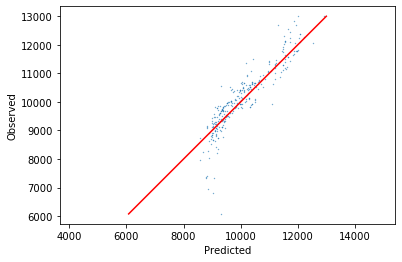

In [17]:
x = preds.reshape(-1) * 2e4
y = obs.reshape(-1) * 2e4

ax = plt.axes()
ax.set_aspect('equal', 'datalim')

plt.scatter(x, y, 0.1, alpha=0.9)
plt.xlabel('Predicted')
plt.ylabel('Observed')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k-', color = 'r')
print(np.round(np.corrcoef(x, y, rowvar=False)[1,0],3)**2)
plt.show()

In [18]:
ymax = pred_dataset[idx_max][1][None].cpu().data.numpy()
ymin = pred_dataset[idx_min][1][None].cpu().data.numpy()
wmax = pred_dataset[idx_max][0][None]
wmin = pred_dataset[idx_min][0][None]
wmaxo = wmax.clone()
wmino = wmin.clone()

wmax.requires_grad = True
wmin.requires_grad = True

In [19]:
ymax_pred = model(wmax).cpu().data.numpy()
ymin_pred = model(wmin).cpu().data.numpy()

In [20]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam([wmax], lr=0.1)

In [21]:
yield_loss = PlotLosses(skip_first = 0)

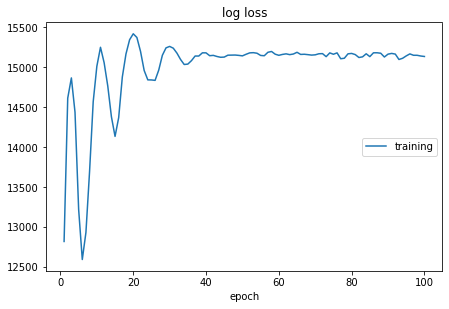

log loss:
training   (min: 12588.089, max: 15419.542, cur: 15134.881)


In [22]:
eps = 0.01
model.eval()
for i in trange(100):

    # Limpa os gradientes
    optimizer.zero_grad()

    # Obtem o output
    outputs = model(wmax)

    # Caulcula a perda pela loss function
    loss = -outputs.mean()
    
    # Use an l2 penalty:
    loss += criterion(wmaxo, wmax)/eps
        
    # Obtem os gradientes
    loss.backward()

    # Atualiza os parâmetros
    optimizer.step()
    
    # Clip to the valid range of values:
    wmax.data = torch.clamp(wmax.data, 0, 1)
    wmax.data[:,-1] = wmaxo[:,-1]

    yield_loss.update({
        'log loss': 2e4 * outputs.mean().item()
    })
yield_loss.draw()

Text(0, 0.5, 'Yield')

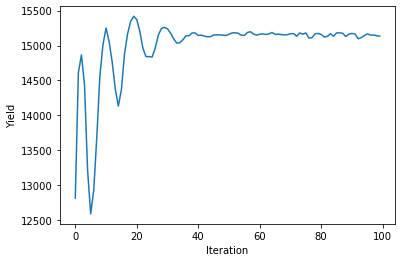

In [23]:
plt.plot(pd.DataFrame(yield_loss.logs).values[:,0])
plt.xlabel('Iteration')
plt.ylabel('Yield')


In [24]:
pred = outputs.cpu().data.numpy()

In [25]:
wmax_np = wmax.data.cpu().numpy()
wmaxo_np = wmaxo.data.cpu().numpy()


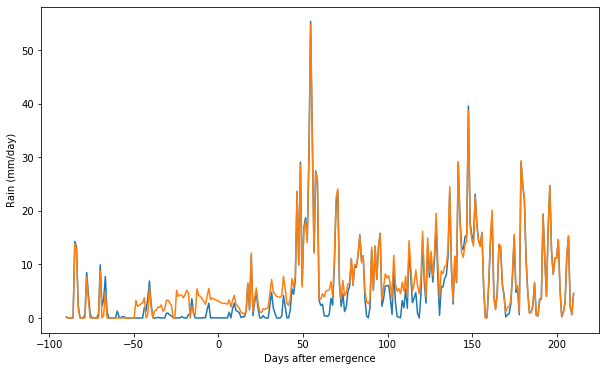

In [26]:
plt.figure(figsize=(10,6))
xx = np.linspace(-90, 210, 300)
plt.plot(xx, 100 * np.stack([wmaxo_np[0,-2], wmax_np[0,-2]], 1))
plt.xlabel('Days after emergence')
plt.ylabel('Rain (mm/day)')
plt.show()

In [27]:
# Save weather data in the format needed
# Run the WOFOST model and compare the results.

In [28]:
# Compare adversarial trained vs plain trained model generalization
# Using FGSM

# Certified robustness wihtin confidence interval